In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from preprocessing import load_if_in_country_or_lang
from preprocessing import categorize_views_for_df
from processing import filter_by_region_cat_code, build_regression_dataframe, load_preprocessed_events
from plot_regression import plot_regression_results_from_dict
import numpy as np
from regression import fit_nb_with_estimated_alpha, estimate_alpha, fit_nb, standardize_var, fit_nb_with_estimated_alpha_all_codes, standardize_var

In [3]:
df_crawled = pd.read_csv('events/new/processed_0_manually_with_wikiviews.csv').drop_duplicates()

In [4]:
df_crawled[df_crawled.cat == 'undefined'].head()

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,in_code_lang,in_code_region,date_month,views_baseline,view_country_article
200,Q107353229,Chinese elephants expedition,2020-03-01,Global South,China,Asia,undefined,"['Category:2021 in China', 'Category:Animal mi...",0,0.000000,...,China,2020.0,10228.970558,1.472280e+13,False,False,False,2020-03-01,1.842000e+06,20676.5
214,Q109110309,Wikipedia:Meetup/Johor 9,2019-05-01,Global South,Malaysia,Asia,undefined,"['Category:Wikipedia meetups in Malaysia', 'Ca...",0,0.000000,...,Malaysia,2019.0,11414.290367,3.646840e+11,False,False,False,2019-05-01,5.815000e+07,9350.0
245,Q138837,Catalan Republic (2017),2017-10-27,Global North,Spain,Europe,undefined,['Category:Redirects connected to a Wikidata i...,392630,0.000000,...,Spain,2017.0,28137.441564,1.312539e+12,True,False,False,2017-10-01,4.312950e+07,11320.0
247,Q1437630,"Solar eclipse of August 21, 2017",2017-08-21,Global North,United States,North America,undefined,"['Category:2017 in science', 'Category:2017 in...",1244878,157979.285714,...,United States,2017.0,59921.674703,1.947962e+13,True,True,True,2017-08-01,3.217767e+09,44815.0
1014,Q22081742,Wikipedia:Meetup/justfortherecord/Events/heroines,2016-01-15,Global North,Belgium,Europe,undefined,[],0,0.000000,...,Belgium,2016.0,41899.065629,4.757396e+11,True,False,False,2016-01-01,2.536950e+07,8722.0


In [5]:
df_crawled = df_crawled[df_crawled.cat != 'undefined']
df_crawled = df_crawled.drop_duplicates()
df_crawled[df_crawled.pagetitle.duplicated(keep=False)]

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,in_code_lang,in_code_region,date_month,views_baseline,view_country_article


In [415]:
df_crawled[df_crawled.views_before_sum > df_crawled.views_7_sum][['code', 'pagetitle','event_date', 'views_before_sum', 'views_7_sum']]

,code,pagetitle,event_date,views_before_sum,views_7_sum
11,en,2020 International Darts Open,2020-10-01,772,313
97,en,2021 New Year Honours (New Zealand),2020-12-31,2043,1875
162,en,2020 Phoenix mayoral election,2020-11-03,3129,2423
243,en,"Nigerien presidential election, 2004",2015-11-16,41,31
277,en,2016 Democratic National Convention,2016-07-25,209073,207141
...,...,...,...,...,...
19544,es,Tianguis Turístico,2019-04-10,1862,741
19559,es,Gran Premio del 70.º Aniversario,2020-08-09,4963,4547
19584,es,Gran Premio de España de Motociclismo de 2020,2020-07-19,1503,1322
19609,es,Gran Premio de Cataluña de Motociclismo de 2020,2020-09-27,751,712


# Analyze views-after vs. views/before

TODO: build a regression which measures if an event gathers more than n views on Wikipedia

In [6]:
for code, df in df_crawled.groupby('code'):
    n_events_total = len(df)
    print(f'Analysing {code} ({n_events_total} Events)')

    for v in [0, 10, 100, 1000]: # [0.05, 1, 5, 10]:
        events_rel = df[(df.views_7_sum <= v)]
        #min_v = v * df.views_baseline / 1000000
        #events_rel = df[df.views_7_sum < min_v]
        n_events_rel = len(events_rel)
        print(f'\tLess than {v+1} views: {n_events_rel} ({n_events_rel/n_events_total*100:.2f}%)')

Analysing de (3375 Events)
	Less than 1 views: 1653 (48.98%)
	Less than 11 views: 1662 (49.24%)
	Less than 101 views: 1811 (53.66%)
	Less than 1001 views: 2568 (76.09%)
Analysing en (8184 Events)
	Less than 1 views: 1283 (15.68%)
	Less than 11 views: 1302 (15.91%)
	Less than 101 views: 1477 (18.05%)
	Less than 1001 views: 3067 (37.48%)
Analysing es (3628 Events)
	Less than 1 views: 770 (21.22%)
	Less than 11 views: 781 (21.53%)
	Less than 101 views: 1124 (30.98%)
	Less than 1001 views: 2256 (62.18%)
Analysing it (2793 Events)
	Less than 1 views: 1155 (41.35%)
	Less than 11 views: 1194 (42.75%)
	Less than 101 views: 1531 (54.82%)
	Less than 1001 views: 2176 (77.91%)


In [7]:
for code, df in df_crawled.groupby('code'):
    n_events_total = len(df)
    print(f'Analysing {code} ({n_events_total} Events)')

    for v in [0.01, 0.05, 0.1, 0.25, 0.5]:
        n_min_events = int(np.ceil(n_events_total*v))
        events_rel = df.nsmallest(n_min_events, 'views_7_sum')
        #min_v = v * df.views_baseline / 1000000
        #events_rel = df[df.views_7_sum < min_v]
        n_events_rel = len(events_rel)
        print(f'\tSmallest {n_min_events} events (bottom {v*100}%): {n_events_rel} ({n_events_rel/n_events_total*100:.2f}%)')
        print(f'\t\tViews by "largest of the smallest": {events_rel.tail(1).views_7_sum.values[0]}')

Analysing de (3375 Events)
	Smallest 34 events (bottom 1.0%): 34 (1.01%)
		Views by "largest of the smallest": 0
	Smallest 169 events (bottom 5.0%): 169 (5.01%)
		Views by "largest of the smallest": 0
	Smallest 338 events (bottom 10.0%): 338 (10.01%)
		Views by "largest of the smallest": 0
	Smallest 844 events (bottom 25.0%): 844 (25.01%)
		Views by "largest of the smallest": 0
	Smallest 1688 events (bottom 50.0%): 1688 (50.01%)
		Views by "largest of the smallest": 31
Analysing en (8184 Events)
	Smallest 82 events (bottom 1.0%): 82 (1.00%)
		Views by "largest of the smallest": 0
	Smallest 410 events (bottom 5.0%): 410 (5.01%)
		Views by "largest of the smallest": 0
	Smallest 819 events (bottom 10.0%): 819 (10.01%)
		Views by "largest of the smallest": 0
	Smallest 2046 events (bottom 25.0%): 2046 (25.00%)
		Views by "largest of the smallest": 334
	Smallest 4092 events (bottom 50.0%): 4092 (50.00%)
		Views by "largest of the smallest": 2853
Analysing es (3628 Events)
	Smallest 37 events

In [8]:
df_crawled['noticed'] = df_crawled.views_7_sum > 10

### Investigation of "noticed" events

In [9]:
from plot_regression import plot_cat_by_cat, plot_cat_by_cat_variable

In [10]:
f'{sum(df_crawled.noticed) / len(df_crawled)*100:.2f}% of OVERALL articles have >10 views'

'72.53% of OVERALL articles have >10 views'

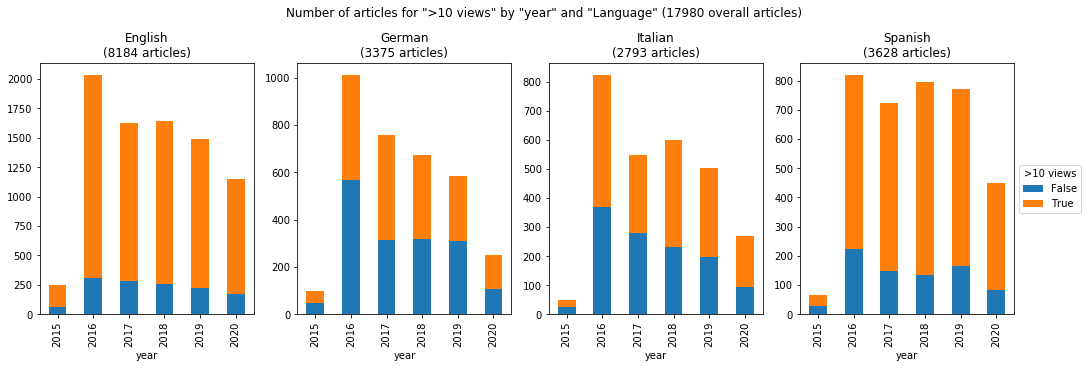

In [11]:
plot_cat_by_cat_variable(df_crawled, col_plot='code', col_x = 'year', col_bar='noticed', stacked=True, sharey=False, figsize=(15, 5))

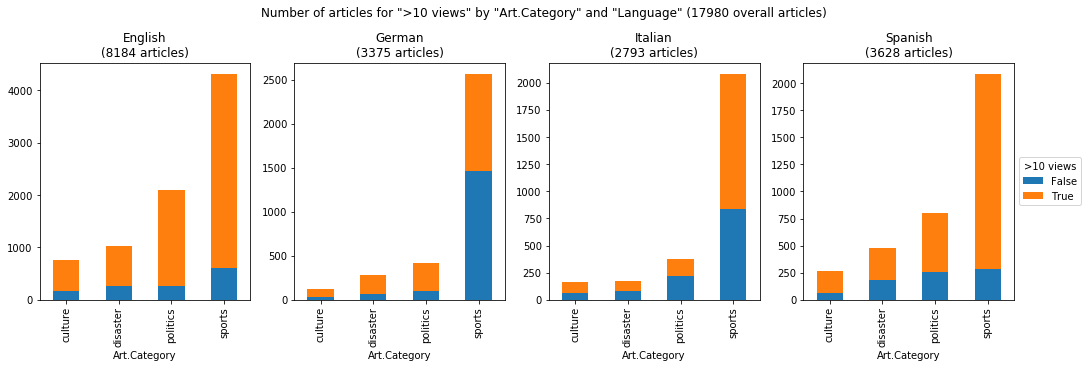

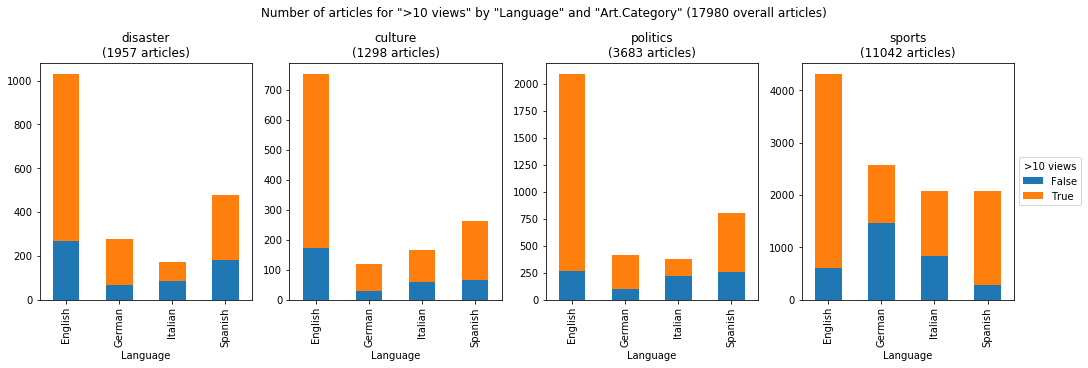

In [12]:
plot_cat_by_cat_variable(df_crawled, col_plot='code', col_x = 'cat', col_bar='noticed', stacked=True, sharey=False, figsize=(15, 5))
plot_cat_by_cat_variable(df_crawled, col_plot='cat', col_x = 'code', col_bar='noticed', stacked=True, sharey=False, figsize=(15, 5))

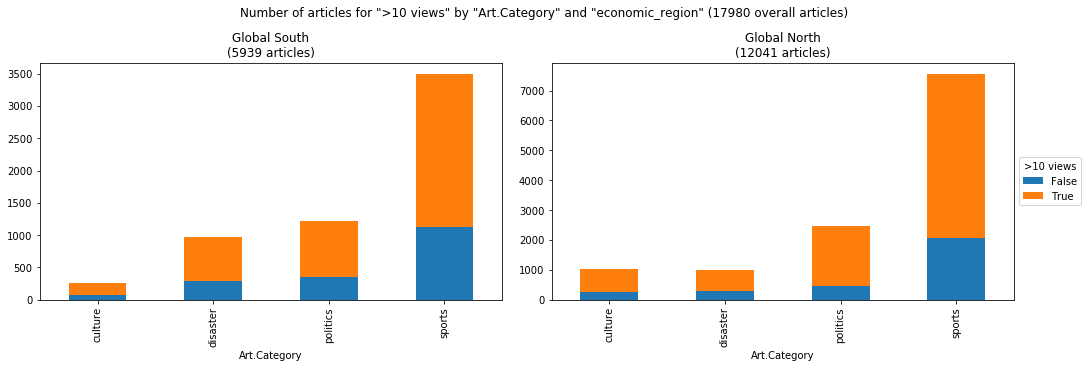

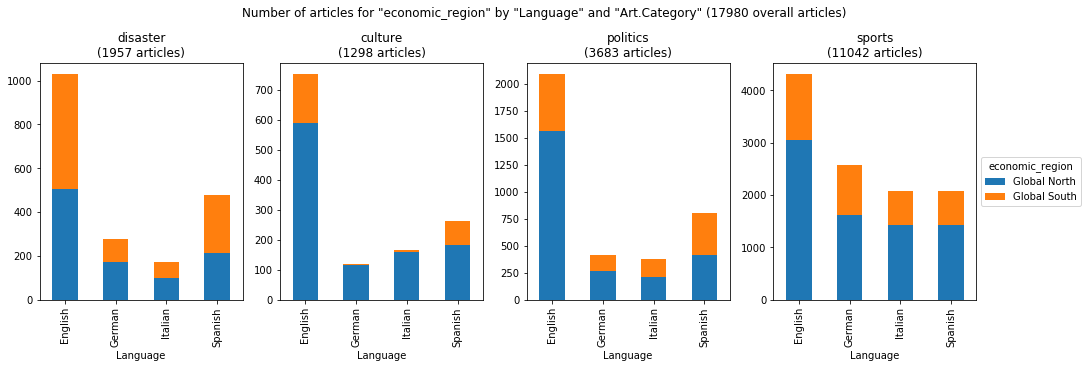

In [13]:
plot_cat_by_cat_variable(df_crawled, col_plot='economic_region', col_x = 'cat', col_bar='noticed', stacked=True, sharey=False, figsize=(15, 5))
plot_cat_by_cat_variable(df_crawled, col_plot='cat', col_x = 'code', col_bar='economic_region', stacked=True, sharey=False, figsize=(15, 5))

# Regression

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plot_regression import BASELINE_DICT, CAT_DICT, LABEL_RENAME_DICT, LABEL_SORT_DICT
from regression import transform_vars_for_regression, fit_logit_and_rename_coeffs, fit_regression_and_rename_coeffs_by_cat, nagelkerke, mcfadden, likelihood_ratio_test
from processing import calculate_uniqueness, calculate_uniqueness_two_columns

df_crawled.event_date = pd.to_datetime(df_crawled.event_date)
df_crawled = calculate_uniqueness(df_crawled, 30, 'country')
df_crawled = calculate_uniqueness(df_crawled, 30, 'cat')
df_crawled = calculate_uniqueness_two_columns(df_crawled, 30, 'country', 'cat')
df_reg = df_crawled[df_crawled.year > 2015].copy()
df_reg = transform_vars_for_regression(df_reg)
df_reg['noticed_int'] = df_reg.noticed.astype(int)

In [21]:
df_reg.describe()

,views_7_sum,views_before_mean,views_before_sum,views_before_max,views_before_min,views_before_median,views_before_increase,diff_days,year,edits_7_sum,...,bing_hits_z,view_country_article_log,views_baseline_log,bing_hits_log,GDP_pc_log,GDP_log,population_log,views_before_log,views_before_z,noticed_int
count,1.752400e+04,17524.000000,1.752400e+04,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,...,1.752400e+04,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,1.752400e+04,17524.000000
mean,1.879354e+04,505.729635,3.478577e+03,945.726432,297.645743,432.918569,487.016149,-19.412406,2017.689226,26.435974,...,9.731240e-18,8.685505,16.197235,6.212895,9.939394,27.755795,17.815382,3.030182,-1.702967e-17,0.727517
std,1.221306e+05,3626.362287,2.535814e+04,6945.623872,2399.728356,3069.400341,4268.468788,507.707605,1.362913,100.797535,...,1.000000e+00,1.292987,3.472149,4.145783,1.151321,2.076593,1.717646,3.626663,1.000000e+00,0.445250
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-35168.000000,-5990.000000,2016.000000,0.000000,...,-2.406814e-01,0.000000,0.000000,0.000000,4.676027,17.665728,9.256747,0.000000,-1.371779e-01,0.000000
25%,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-79.000000,2016.000000,0.000000,...,-2.406252e-01,7.802822,13.570889,2.756454,9.076299,26.605787,16.731682,0.000000,-1.371779e-01,0.000000
50%,6.005000e+02,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-3.000000,2018.000000,2.000000,...,-2.403270e-01,8.777247,16.494303,4.543295,10.409898,28.131505,18.006057,0.000000,-1.371779e-01,1.000000
75%,5.581500e+03,105.571429,5.840000e+02,195.000000,48.000000,83.000000,79.000000,6.000000,2019.000000,17.000000,...,-1.557060e-01,9.495068,18.543106,10.012387,10.818299,28.696005,19.144178,6.371612,-1.141478e-01,1.000000
max,7.847440e+06,188749.000000,1.321243e+06,443489.000000,134559.000000,150619.000000,316295.000000,2143.000000,2020.000000,3887.000000,...,2.997703e+01,10.933393,21.963427,15.886164,12.152185,30.693130,21.067514,14.094084,5.196613e+01,1.000000


# Predicting extra-media events using all news values

In [109]:
code_reg = 'C(code, Treatment(reference="en"))'
cat_reg = 'C(cat, Treatment(reference="sports"))'
class_reg = 'C(gni_class, Treatment(reference="H"))'
region_reg = 'C(gni_region, Treatment(reference="North America"))'
continent_reg = 'C(continent, Treatment(reference="North America"))'
relevance_reg = 'views_baseline_log'
magnitude = 'population_log'
prominence = 'view_country_article_log'
power_elite = f'GDP_pc_z + {class_reg} + economic_region + oecd'
uniqueness = 'country_articles_log + cat_articles_log + country_cat_articles_log'

## All News Value features

In [110]:
logreg_0 = fit_logit_and_rename_coeffs(df_reg, f'noticed_int ~ {code_reg} * ({cat_reg} + {relevance_reg} + {region_reg} + {magnitude} + {prominence} + {uniqueness} + {power_elite})')
logreg_0.summary()

PseudoR² - Nagelkerke: 0.224 | Mcfadden: 0.143


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            noticed_int   No. Observations:                17524
Model:                            GLM   Df Residuals:                    17436
Model Family:                Binomial   Df Model:                           87
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8791.3
Date:                Tue, 10 May 2022   Deviance:                       17583.
Time:                        09:26:56   Pearson chi2:                 1.74e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               0.4504      0.850      0.530      0.596      -1.216       2.117
code[T.de]                                             -5.5119      1.144     -4.818      0.000      -7.754      -3.270
code[T.es]                                             -0.4609      1.210     -0.381      0.703      -2.833       1.911
code[T.it]                                             -3.2084      1.174     -2.733      0.006      -5.509      -0.908
cat[T.culture]                                          0.0284      0.150      0.189      0.850      -0.265       0.322
cat[T.disaster]                                        -0.2310      0.133     -1.740      0.082      -0.491       0.029
cat[T.politics]                                         0.4311      0.115      3.762      0.000       0.207       0.656
gni_region[T.East Asia & Pacific]                      -0.1821      0.160     -1.138      0.255      -0.496       0.131
gni_region[T.Europe & Central Asia]                    -0.3178      0.147     -2.162      0.031      -0.606      -0.030
gni_region[T.Latin America & Caribbean]                 0.3219      0.220      1.465      0.143      -0.109       0.753
gni_region[T.Middle East & North Africa]                0.1310      0.254      0.515      0.607      -0.368       0.630
gni_region[T.South Asia]                               -0.9231      0.227     -4.071      0.000      -1.368      -0.479
gni_region[T.Sub-Saharan Africa]                       -0.4442      0.276     -1.611      0.107      -0.985       0.096
gni_class[T.L]                                          0.5488      0.321      1.711      0.087      -0.080       1.177
gni_class[T.LM]                                         0.1791      0.224      0.798      0.425      -0.261       0.619
gni_class[T.UM]                                         0.0680      0.168      0.405      0.686      -0.261       0.397
economic_region[T.Global South]                        -0.3014      0.198     -1.522      0.128      -0.689       0.087
oecd[T.True]                                           -0.4414      0.111     -3.961      0.000      -0.660      -0.223
code[T.de]:cat[T.culture]                               1.4444      0.350      4.130      0.000       0.759       2.130
code[T.es]:cat[T.culture]                              -0.6498      0.270     -2.405      0.016      -1.179      -0.120
code[T.it]:cat[T.culture]                              -0.2934      0.287     -1.023      0.306      -0.856       0.269
code[T.de]:cat[T.disaster]                              1.9950      0.271      7.359      0.000       1.464       2.526
code[T.es]:cat[T.disaster]                             -0.9899      0.215     -4.60

In [112]:
independent = f'{cat_reg} + {relevance_reg} + {region_reg} + {magnitude} + {prominence} + {uniqueness} + {power_elite}'
logit0_dict = fit_regression_and_rename_coeffs_by_cat(df_reg,  f'noticed_int ~ {independent}', type='logit', show_summary=True, max_iter=100)

PseudoR² - Nagelkerke: 0.047 | Mcfadden: 0.032
PseudoR² - Nagelkerke: 0.221 | Mcfadden: 0.131
PseudoR² - Nagelkerke: 0.091 | Mcfadden: 0.051
PseudoR² - Nagelkerke: 0.108 | Mcfadden: 0.070
--------------- Summary for en ---------------
PseudoR² - Nagelkerke: 0.047 | Mcfadden: 0.032
                           Results: Generalized linear model
Model:                      GLM                      AIC:                    6712.5174  
Link Function:              logit                    BIC:                    -64412.5447
Dependent Variable:         noticed_int              Log-Likelihood:         -3334.3    
Date:                       2022-05-10 09:27         LL-Null:                -3444.8    
No. Observations:           7938                     Deviance:               6668.5     
Df Model:                   21                       Pearson chi2:           7.87e+03   
Df Residuals:               7916                     Scale:                  1.0000     
Method:                     IRLS  

['C(cat, Treatment(reference="sports"))', 'views_baseline_log', 'C(gni_region, Treatment(reference="North America"))', 'population_log', 'view_country_article_log', 'country_articles_log', 'cat_articles_log', 'C(gni_class, Treatment(reference="H"))']


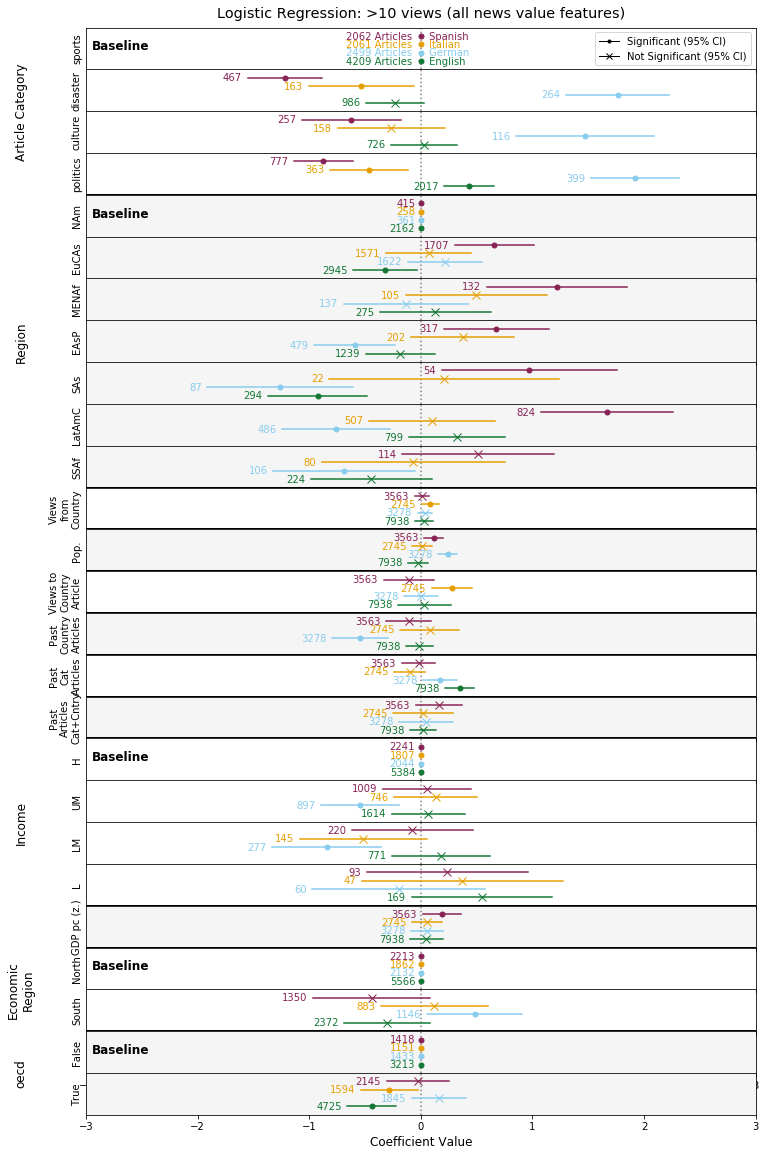

In [160]:
coefficients = [string.strip() for string in independent.split('+')]
print(coefficients)
figres = plot_regression_results_from_dict(
    df_reg, logit0_dict, 
    ['cat',  'gni_region', 'views_baseline_log', 'population_log', 'view_country_article_log', 'country_articles_log', 'cat_articles_log', 'country_cat_articles_log', 'gni_class', 'GDP_pc_z', 'economic_region', 'oecd'], 
    include_counts=True, figsize=(12, 20), x_limits=(-3,3), title=f'Logistic Regression: >10 views (all news value features)')
figres.savefig('figures/isnoted_all.pdf', bbox_inches='tight')

### News Value feature selection

In [156]:
relevance_reg = 'views_baseline_log'
magnitude = 'population_log'
prominence = 'view_country_article_log'
power_elite = f'{class_reg}' #f'GDP_pc_z + {class_reg} + economic_region + oecd'
uniqueness = 'country_articles_log + cat_articles_log'
independent1 = f'{cat_reg} + {relevance_reg} + {region_reg} + {magnitude} + {prominence} + {uniqueness} + {power_elite}'

logreg_1 = fit_logit_and_rename_coeffs(df_reg, f'noticed_int ~ {independent1}')
logreg_1.summary()

PseudoR² - Nagelkerke: 0.108 | Mcfadden: 0.066


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            noticed_int   No. Observations:                17524
Model:                            GLM   Df Residuals:                    17506
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9587.7
Date:                Tue, 10 May 2022   Deviance:                       19175.
Time:                        12:07:09   Pearson chi2:                 1.75e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -2.6281      0.311     -8.446      0.000      -3.238      -2.018
cat[T.culture]                              -0.0759      0.095     -0.803      0.422      -0.261       0.110
cat[T.disaster]                             -0.1901      0.079     -2.395      0.017      -0.346      -0.035
cat[T.politics]                              0.2290      0.063      3.627      0.000       0.105       0.353
gni_region[T.East Asia & Pacific]            0.1504      0.080      1.891      0.059      -0.006       0.306
gni_region[T.Europe & Central Asia]          0.2081      0.065      3.210      0.001       0.081       0.335
gni_region[T.Latin America & Caribbean]      0.2997      0.090      3.344      0.001       0.124       0.475
gni_region[T.Middle East & North Africa]     0.5372      0.118      4.537      0.000       0.305       0.769
gni_region[T.South Asia]                    -0.5547      0.141     -3.931      0.000      -0.831      -0.278
gni_region[T.Sub-Saharan Africa]            -0.0179      0.141     -0.127      0.899      -0.295       0.259
gni_class[T.L]                               0.8399      0.159      5.288      0.000       0.529       1.151
gni_class[T.LM]                              0.1713      0.088      1.945      0.052      -0.001       0.344
gni_class[T.UM]                              0.1626      0.061      2.653      0.008       0.042       0.283
views_baseline_log                           0.0686      0.014      4.980      0.000       0.042       0.096
population_log                              -0.0793      0.016     -5.089      0.000      -0.110      -0.049
view_country_article_log                     0.4281      0.035     12.080      0.000       0.359       0.498
country_articles_log                        -0.0782      0.020     -3.964      0.000      -0.117      -0.040
cat_articles_log                             0.0376      0.030      1.266      0.205      -0.021       0.096
============================================================================================================
"""

In [142]:
logit1_dict = fit_regression_and_rename_coeffs_by_cat(df_reg,  f'noticed_int ~ {independent1}', type='logit', show_summary=True, max_iter=100)

PseudoR² - Nagelkerke: 0.044 | Mcfadden: 0.030
PseudoR² - Nagelkerke: 0.219 | Mcfadden: 0.130
PseudoR² - Nagelkerke: 0.088 | Mcfadden: 0.050
PseudoR² - Nagelkerke: 0.103 | Mcfadden: 0.067
--------------- Summary for en ---------------
PseudoR² - Nagelkerke: 0.044 | Mcfadden: 0.030
                           Results: Generalized linear model
Model:                      GLM                      AIC:                    6721.2177  
Link Function:              logit                    BIC:                    -64431.7621
Dependent Variable:         noticed_int              Log-Likelihood:         -3342.6    
Date:                       2022-05-10 11:57         LL-Null:                -3444.8    
No. Observations:           7938                     Deviance:               6685.2     
Df Model:                   17                       Pearson chi2:           7.87e+03   
Df Residuals:               7920                     Scale:                  1.0000     
Method:                     IRLS  

cat + gni_region + views_baseline_log + population_log + view_country_article_log + country_articles_log + cat_articles_log + gni_class
C(cat, Treatment(reference="sports")) + views_baseline_log + C(gni_region, Treatment(reference="North America")) + population_log + view_country_article_log + country_articles_log + cat_articles_log + C(gni_class, Treatment(reference="H"))


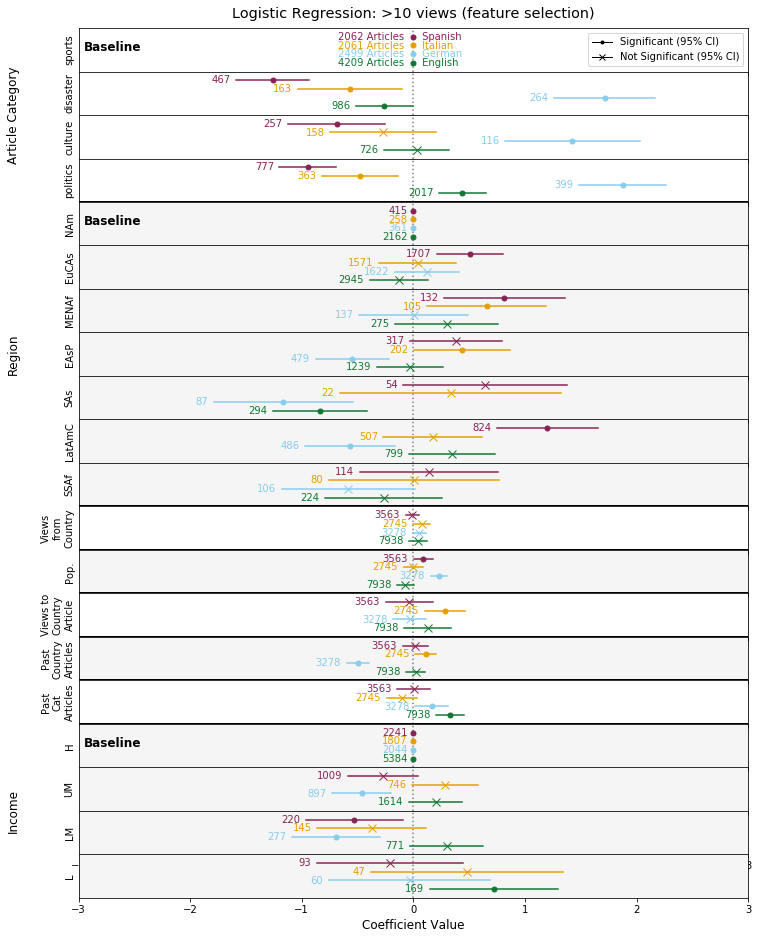

In [159]:
list_coefs = ['cat',  'gni_region', 'views_baseline_log', 'population_log', 'view_country_article_log', 'country_articles_log', 'cat_articles_log', 'gni_class']
print(" + ".join(list_coefs))
figres = plot_regression_results_from_dict(
    df_reg, logit1_dict, 
    list_coefs, 
    include_counts=True, figsize=(12, 16), x_limits=(-3,3), title=f'Logistic Regression: >10 views (feature selection)')
print(independent1)
figres.savefig('figures/isnoted_select.pdf', bbox_inches='tight')